In [1]:
using LinearAlgebra
using Plots
import Roots # Root finding, I am using root_find
import Random
import StatsBase

In [20]:
# The System is defined by the jump operators and the Hamiltonian
struct System
    NLEVELS::Int64 #Number of levels of the system
    H::Matrix{ComplexF64} # Hamiltonian
    Ls::Vector{Matrix{ComplexF64}} # List of jump operators
    J::Matrix{ComplexF64} # Sum of Jump operators
    Heff::Matrix{ComplexF64} # Effective Hamiltonian
    # ExpHeff::Function # Function that calculates the exponential of Heff at tau
    # JumpSuperOperators::Vector{Function}  # Jump super operators
    # NoJumpSuperOperator::Function # No-Jump superoperator
    # Inner Constructor
    function System(H::Matrix{ComplexF64}, Ls::Vector{Matrix{ComplexF64}})
        NLEVELS = size(H)[1] 
        NCHANNELS = size(Ls)[1] # Number of jump channels
        J = zeros(ComplexF64, NLEVELS, NLEVELS) 
        for L in Ls
            J = J + adjoint(L)*L
        end 
        CurvyLs = Vector{Function}(undef, NCHANNELS)
       # for k in 1:NCHANNELS
       #     CurvyLs[k] = rho::Matrix{ComplexF64} -> Ls[k]*rho*adjoint(Ls[k])
       # end 
        He = H - 0.5im*J
       # expHe(tau::Float64) =  expm(-1im*tau*He)
       # function expcurvyL0(rho::Matrix{ComplexF64}, tau::Float64)
       #     A = expHe(tau)
       #     return A*rho*adjoint(A)
       # end 
       # new(NLEVELS, H, Ls, J, He, expHe, CurvyLs, expcurvyL0)
        new(NLEVELS, H, Ls, J, He)
    end 
end 
Base.show(io::IO, s::System) = print(io, 
    "System(NLEVELS=$(s.NLEVELS)\nH=$(s.H)\nLs=$(s.Ls)\nJ=$(s.J))\nHeff=$(s.Heff))")

In [3]:
# Trajectory Struct
struct Trajectory
    times::Vector{Float64} # detection times
    states::Vector{Vector{ComplexF64}} #States after jump
    labels::Vector{Int64} # Labels 
end 

In [21]:
# Simulation Struct, it contains the data necessary to run the simulation
# and the precomputed values
struct SimulParameters
    psi0::Vector{Float64}
    nsamples::Int64 # Number of samples in the finegrid
    seed::Int64 # seed
    ntraj::Int64 # Number of trajectories
    multiplier::Float64 # Multiplier to use in the fine grid
    tf::Float64 # Final time
    dt::Float64 # time step for the finegrid
    eps::Float64 # Tolerance for passing WTD normalziation
    function SimulParameters(psi0::Vector{ComplexF64}, tf::Float64,
        s::Int64, ntraj::Int64, nsamples::Int64=10000, m::Int64=10 ,eps::Float64=1e-3)
        deltat = m*tf/nsamples
        new(psi0, nsamples, s, ntraj, m, tf, deltat, eps)
    end 
end 
Base.show(io::IO, s::SimulParameters) = print(io, 
    "SimulParameters(psi0=$(s.psi0)\nnsamples=$(s.nsamples)\nseed=$(s.seed)\nntraj=$(s.ntraj))\nmultiplier=$(s.multiplier)\ntf=$(s.tf)\ndt=$(s.dt)\neps=$(s.eps))")

In [5]:
############# Precomputation routine ######################
# Input: 
# 1. From the System: J and Heff
# 2. From the simulation parameters: tf, nsamples and the multiplier
# Output: (ts, Qs), a tuple with the finegrid and the precomputed values of the transformed J
function precompute(J::Matrix{ComplexF64}, Heff::Matrix{ComplexF64}, 
        tf::Float64, nsamples::Int64, multiplier::Float64)
        ts = LinRange(0, multiplier*tf, nsamples)
        Qs = Vector{Matrix{ComplexF64}}(undef, nsamples) 
        for k in 1:nsamples
            expm = exp(-1im*ts[k]*Heff) 
            Qs[k] = expm * J * adjoint(expm)
        end 
        return ts, Qs
end 
############# Single Trajectory Routine ######################
# Input:
# 1. From the System: Ls and Heff
# 2. From the Simulation Parameters: psi0, tf, nsamples, dt and eps
# Output:
# A trajectory object with the data of the trajectory
function run_single_trajectory(sys::System, params::SimulParameters)
    # System 
    J = sys.J
    Heff = sys.Heff
    Ls = sys.Ls
    # Simulation parameters
    tf = params.tf 
    nsamples = params.nsamples
    dt = params.dt
    eps = params.eps
    # Random number generator
    Random.seed!(params.seed)
    # Store 
    W = zeros(Float64, nsamples) # Vector to store the weights of the fine grid
    times = Vector{Float64}()
    labels = Vector{Int64}()
    states = Vector{Vector{ComplexF64}}()
     
   # 1. Set Initial condition
    psi = params.psi0
    t = 0
    # 2. Precomputing 
    ts, Qs =  precompute(J, Heff, tf, nsamples, params.multiplier)
    # 3. Run the trajectory
    while t < tf
    # 1. Calculate the WTD for the state, these act as weights
        for k in 1:nsamples
           W[k] = real(dot(conj.(psi), Qs[k]*psi)) 
        end 
        # 1.a We must verify if we got a dark state, that can be cheked by 
        # looking at the normalization of the QTD
        if abs(sum(W)*dt - 1) > eps
            break
        end 
        # 2. Sample jump time
        tau = StatsBase.sample(ts, StatsBase.weights(W))
        t = tau + t
        if t>tf # If the next jump happens after tf, stop 
            break
        end 
        psi_tilde = exp(-1im*tau*Heff) * Ls[1]*psi # State without normalization
        psi = psi_tilde / norm(psi_tilde)
        push!(states, psi)
        push!(labels, 1)
        push!(times, t)
    end 
    return Trajectory(times, states, labels) 
end 

run_single_trajectory (generic function with 1 method)

In [46]:
function run_trajectories(sys::System, params::SimulParameters)
    # System 
    J = sys.J
    Heff = sys.Heff
    Ls = sys.Ls
    # Simulation parameters
    tf = params.tf 
    nsamples = params.nsamples
    dt = params.dt
    eps = params.eps
    ntraj = params.ntraj
   # Store 
    W = zeros(Float64, nsamples) # Vector to store the weights of the fine grid
    times = Vector{Float64}()
    labels = Vector{Int64}()
    states = Vector{Vector{ComplexF64}}()
    data = Vector{Trajectory}(undef, ntraj)
    # Precomputing 
    ts, Qs =  precompute(J, Heff, tf, nsamples, params.multiplier)
    for k in 1:ntraj 
        # Set Initial condition
        psi = params.psi0
        t = 0
        # Random number generator
        Random.seed!(params.seed + k)
       #  Run the trajectory
        while t < tf
        # 1. Calculate the WTD for the state, these act as weights
            for k in 1:nsamples
               W[k] = real(dot(conj.(psi), Qs[k]*psi)) 
            end 
            # 1.a We must verify if we got a dark state, that can be cheked by 
            # looking at the normalization of the QTD
            if abs(sum(W)*dt - 1) > eps
                break
            end 
            # 2. Sample jump time
            tau = StatsBase.sample(ts, StatsBase.weights(W))
            t = tau + t
            if t>tf # If the next jump happens after tf, stop 
                break
            end 
            psi_tilde = exp(-1im*tau*Heff) * Ls[1]*psi # State without normalization
            psi = psi_tilde / norm(psi_tilde)
            push!(states, psi)
            push!(labels, 1)
            push!(times, t)
        end 
            data[k] =  Trajectory(copy(times), copy(states), copy(labels))
            empty!(states)
            empty!(labels)
            empty!(times)
    end 
    return data
end 

run_trajectories (generic function with 1 method)

In [53]:
################### Qubit decay example ######################
#### 1. Create the system instance
gamma = 1
sigma_m = [[0.0+0im, 0]  [1, 0]]
sys = System( zeros(ComplexF64, 2, 2), # Hamiltonian
    [sqrt(gamma)*sigma_m ]) #Jump Operators
#### 2. Create the simulation parameters instance
psi0 = zeros(ComplexF64, 2)
psi0[2] = 1 # Initial condition
simulparams = SimulParameters(psi0,
    10.0, # Final time. Set very long so that all trajectories jump
    4, # seed
    1000, # Number of trajectories
    100_000, # Number of samples in the finegrid
    1, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing WTD normalziation
) 
### 3. Run a single trajectory
#data = run_single_trajectory(sys, simulparams)

SimulParameters(psi0=[0.0, 1.0]
nsamples=100000
seed=4
ntraj=1000)
multiplier=1.0
tf=10.0
dt=0.0001
eps=0.001)

In [56]:
# To see if we actually got it right, run many trajectories and see if the jump times are exponentially distributed
N = 1000
times = Vector{Float64}(undef, N)

1000-element Vector{Float64}:
   6.90211261368216e-310
   4.126166475e-315
   3.990139847e-315
   4.126166475e-315
   4.14235104e-315
   0.0
   2.1219957905e-314
   0.0
   0.0
   8.487983168e-314
   3.1829953054e-313
   1.6189e-319
   4.00400317e-315
   ⋮
 NaN
   4.140051893e-315
   2.121995791e-314
   4.074596535e-315
   4.14005201e-315
   2.121995791e-314
   0.0
   4.14005213e-315
   2.121995791e-314
   4.10723881e-315
   4.14005225e-315
   2.121995791e-314

In [54]:
@time begin
data = run_trajectories(sys, simulparams)
end 

 78.733204 seconds (1.00 G allocations: 43.548 GiB, 11.94% gc time)


1000-element Vector{Trajectory}:
 Trajectory([3.798837988379884], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([1.801518015180152], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([0.27940279402794027], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([0.5473054730547305], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([0.3895038950389504], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([0.3581035810358103], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([0.8686086860868608], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([0.3859038590385904], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([0.16410164101641017], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([1.7077170771707717], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajectory([0.3884038840388404], Vector{ComplexF64}[[1.0 + 0.0im, 0.0 + 0.0im]], [1])
 Trajector

In [57]:
for k in 1:N
    times[k] = data[k].times[1] 
end 

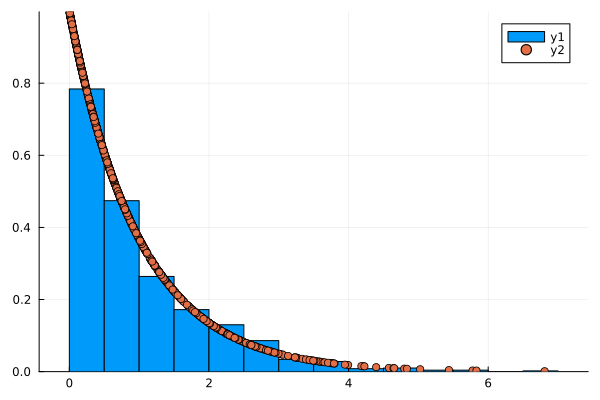

In [58]:
histogram(times, normalize=:pdf)
scatter!(times, exp.(-times))

# 